<a href="https://colab.research.google.com/github/rikunemu/data_study/blob/main/mask_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#マスクデータのモデル作成及びテスト(CNN)


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/data分析/Face Mask Dataset/'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

In [ ]:
train_withmask_dir = os.path.join(train_dir, 'WithMask')
train_withoutmask_dir = os.path.join(train_dir, 'WithoutMask')
validation_withmask_dir = os.path.join(validation_dir, 'WithMask')
validation_withoutmask_dir = os.path.join(validation_dir, 'WithoutMask')
test_withmask_dir = os.path.join(test_dir, 'WithMask')
test_withoutmask_dir = os.path.join(test_dir, 'WithoutMask')

##binaryとcategoricalの違い
binaryは0か1かを判定するので2値判定するのに適している  
categoricalは多クラス分類するのに適している  
今回は2つの値を入手する必要があったためcategoricalを使用

##batch_size
ミニバッチ学習に使われるバッチのサイズ  
データの枚数で割り切れるように調整する必要がある  
データの数=batch_size*epochs

##その他
rescaleは正規化のための仕組みでRGB(0~255)で読み込まれた各画素のRGB値を0から1に収まるように正規化
  
target_sizeでサイズ調整

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 40,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'categorical'
)

Found 10040 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (40, 150, 150, 3)
labels batch shape: (40, 2)


##モデル作成
出力層はsigmoidとsoftmax  
softmaxを使うとどの特徴にも当てはまらないものも高い数字が出る可能性がある  
imput_shape:横,縦,チャンネル数(今回はRGBなので3)  
層を深くしすぎると表現力を失い一直線になる  
Conv2D(16,(3,3)): 3*3の大きさのフィルタを16種類使用  
activation='relu': Relu関数　0より大きい場合はそのまま、0未満は0


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid')) 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

##Adam
MomentumとAdaGradを融合したような手法

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

モデルを保存　再利用するときに便利

In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Mask Dataset/model.h5')

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=251,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=41)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
251/251 [==============================] - 2423s 10s/step - loss: 0.1510 - accuracy: 0.9411 - val_loss: 0.0429 - val_accuracy: 0.9866
Epoch 2/10
251/251 [==============================] - 377s 2s/step - loss: 0.0450 - accuracy: 0.9836 - val_loss: 0.0280 - val_accuracy: 0.9902
Epoch 3/10
251/251 [==============================] - 376s 1s/step - loss: 0.0269 - accuracy: 0.9904 - val_loss: 0.0380 - val_accuracy: 0.9866
Epoch 4/10
251/251 [==============================] - 374s 1s/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0207 - val_accuracy: 0.9939
Epoch 5/10
251/251 [==============================] - 373s 1s/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0259 - val_accuracy: 0.9915
Epoch 6/10
251/251 [==============================] - 372s 1s/step - loss: 0.0098 - accuracy: 0.9960 - val_loss: 0.0294 - val_accuracy: 0.9927
Epoch 7/10
251/251 [==============================] - 371s 1s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0222 - val_accuracy: 0.99

重みを保存　再利用するときに便利


In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Mask Dataset/mask.h5')

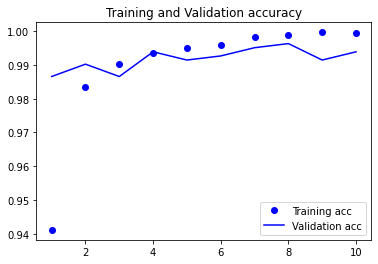

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Mask Dataset/accuracy.png')
plt.show()
plt.close()

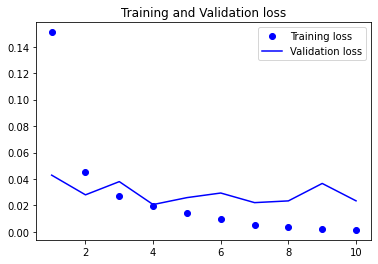

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Mask Dataset/loss.png')
plt.show()
plt.close()

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/MyDrive/data分析/Face Mask Dataset/history.csv')

In [ ]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.150955,0.941135,0.042928,0.986585
1,0.045008,0.983566,0.028047,0.990244
2,0.026877,0.990438,0.038037,0.986585
3,0.019846,0.993426,0.020697,0.993902
4,0.014271,0.995020,0.025939,0.991463
5,0.009801,0.996016,0.029420,0.992683
6,0.005398,0.998406,0.022154,0.995122
7,0.003428,0.999004,0.023468,0.996341
8,0.002025,0.999701,0.036655,0.991463
9,0.001528,0.999502,0.023512,0.993902


In [ ]:
# モデルと重みの読み込み
model.load_weights('/content/drive/MyDrive/data分析/Face Mask Dataset/mask.h5')

In [ ]:
test_generater = test_datagen.flow_from_directory(
    test_dir,
    target_size =  (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 992 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generater, steps=31)
print('test acc:', test_acc)
print('test loss', test_loss)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9889112710952759
test loss 0.05744926258921623


In [ ]:
import tensorflow as tf
desu='/content/drive/MyDrive/data分析/Face Mask Dataset'
modeldesu = tf.keras.models.load_model(desu+'/model.h5')

modeldesu.load_weights(desu+'/mask.h5')

In [ ]:
import tensorflow as tf
from PIL import Image, ImageOps
filename = test_withoutmask_dir + ('/46.png')
img = Image.open(filename)

#img = np.array(img).flatten() / 255
#img = Image.fromarray(img)
img = img.resize((150, 150))
img = np.expand_dims(img,0)
img = img / 255.0
img_array = np.expand_dims(np.array(img).flatten() / 255,0)

In [ ]:
img_array = np.array(img)
# 推論
result=modeldesu.predict(img_array)
#result=tf.nn.sigmoid(modeldesu.predict(img_array[None,...]))
1 - np.float(result[0][0])  # 1に近いほどマスク

0.9975512027740479